In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import os
import galsim
from galsim.angle import radians, arcsec, degrees, AngleUnit
import numpy as np
import matplotlib.pylab as plt
import time
import sys

sys.path.append('/Users/andypark/Desktop/phd/batsim')

from astropy import wcs
from astropy.io import fits
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename

import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

In [2]:
wcsfile = "./eimage_00182850-0-i-R22_S11-det000.fits"
f = fits.open(wcsfile)
w = WCS(f[0].header)
w.sip.a[1, 0] += 1.
w.sip.b[0, 1] += 1.

# Galsim

In [3]:
wcs_g = galsim.GSFitsWCS(wcsfile)
skypos = wcs_g.toWorld(galsim.PositionI(0, 0))
skypos.ra.deg, skypos.dec.deg

(51.793908983991834, -40.26485572360853)

In [4]:
wcs_g = galsim.GSFitsWCS("./eimage_00182850-0-i-R22_S11-det000.fits")
skypos = wcs_g.toWorld(galsim.PositionD(3, 3))
skypos.ra.deg, skypos.dec.deg

(51.794199400833755, -40.26493631713106)

# Manual?

Let $x, y$ be the relative pixel coordinates with origin at $\mathrm{CRPIX1}$ and $\mathrm{CRPIX2}$ and $u, v$ be the coordinates on the tangent plane of the celestial sphere
$$
\begin{pmatrix}u \\ v\end{pmatrix} = \begin{pmatrix}\mathrm{CD1\_1} & \mathrm{CD1\_1} \\ \mathrm{CD2\_1} & \mathrm{CD2\_2}\end{pmatrix}\begin{pmatrix}x + f(x, y) \\ y + g(x, y)\end{pmatrix}$$

The distortion matrix can be written as
$$
\begin{pmatrix}du \\ dv\end{pmatrix} = \begin{pmatrix}\partial_x u & \partial_y u \\ \partial_x v & \partial_y v\end{pmatrix}\begin{pmatrix}dx \\ dy\end{pmatrix} = M\begin{pmatrix}1 - g_1 & -g_2 + \theta \\ -g_2-\theta & 1+g_1\end{pmatrix}\begin{pmatrix}dx \\ dy\end{pmatrix}$$

and Field-Distortion Shear as
$$g_1(\mathrm{FD}) = (\partial_y v - \partial_x u) / (\partial_y v + \partial_x u)$$ and 
$$g_2(\mathrm{FD}) = -(\partial_x v - \partial_y u) / (\partial_y v + \partial_x u)$$

In [5]:
def get_radec(params, w):
    params = jnp.asarray(params)
    params = params.astype(jnp.float64)
    u, v = get_uv(params, w)
    # 4) turn u, v into ra, dec
    cra, cdec = w.wcs.crval * degrees
    cra = cra.rad
    cdec = cdec.rad
    #u = u * radians / degrees
    #v = v * radians / degrees
    rsq = u * u
    rsq += v * v
    cosc = sinc_over_r = 1./jnp.sqrt(1.+rsq)
    sindec = v * sinc_over_r
    sindec *= jnp.cos(cdec)
    sindec += cosc * jnp.sin(cdec)
    tandra_num = u * sinc_over_r
    tandra_num *= -1.
    tandra_denom = v * sinc_over_r
    tandra_denom *= -jnp.sin(cdec)
    tandra_denom += cosc * jnp.cos(cdec)
    dec = jnp.arcsin(sindec)
    ra = cra + jnp.arctan2(tandra_num, tandra_denom)
    #center = galsim.CelestialCoord(w.wcs.crval[0] * degrees, w.wcs.crval[1] * degrees)
    #ra, dec = center.deproject_rad(u, v, "gnomonic")
    return ra * 180 / np.pi, dec * 180 / np.pi

In [6]:
def get_uv(params, w):
    params = jnp.asarray(params).astype(jnp.float32)
    x, y = params
    x -= w.wcs.crpix[0]
    y -= w.wcs.crpix[1] 

    f = 0
    for p in range(w.sip.a_order+1):
        for q in range(w.sip.a_order+1):
            f += w.sip.a[p, q] * jnp.power(x, p) * jnp.power(y, q)
    g = 0
    for p in range(w.sip.a_order+1):
        for q in range(w.sip.a_order+1):
            g += w.sip.b[p, q] * jnp.power(x, p) * jnp.power(y, q)

    x += f
    y += g
    u, v = w.wcs.cd @ jnp.array([x, y])
    factor = 1. * degrees / radians
    u *= -factor
    v *= factor
    return u, v

In [7]:
shape = (4096, 4004)
indx = np.arange(shape[0], dtype=float)
indy = np.arange(shape[1], dtype=float)
inds = np.meshgrid(indy, indx, indexing="ij")
coords = jnp.vstack([np.ravel(_) for _ in inds[::-1]]).T

In [8]:
dget_uv = jax.vmap(jax.jacfwd(get_radec, 0), in_axes=[0, None])(coords, w)

In [9]:
du_dxy, dv_dxy = dget_uv
du_dx, du_dy = du_dxy.T
dv_dx, dv_dy = dv_dxy.T
g1_fd = (dv_dy - du_dx) / (dv_dy + du_dx)
g1_fd = np.reshape(g1_fd, shape)
g2_fd = -(dv_dx + du_dy) / (dv_dy + du_dx)
g2_fd = np.reshape(g2_fd, shape)

Text(0.5, 0, 'g')

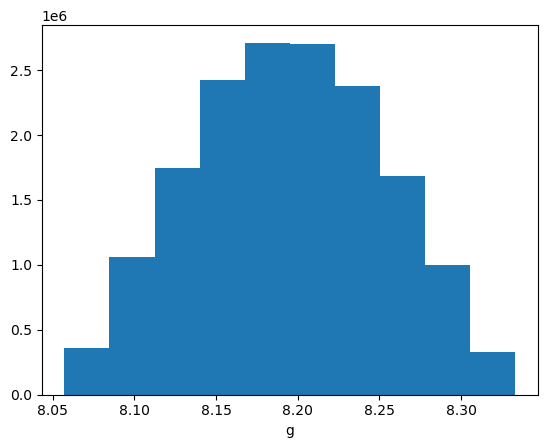

In [10]:
plt.hist(np.sqrt(g1_fd ** 2 + g2_fd ** 2).flatten())
plt.xlabel('g')

Text(0.5, 1.0, 'g2')

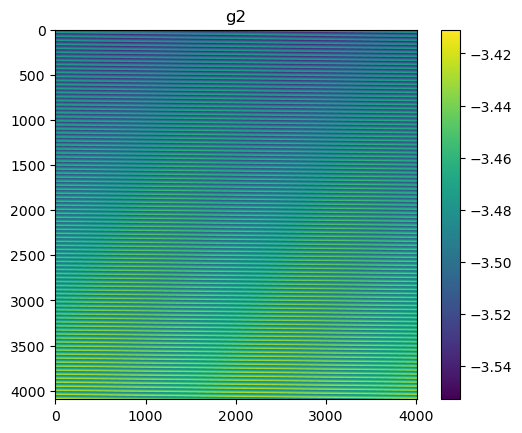

In [11]:
plt.imshow(g2_fd)
plt.colorbar()
plt.title('g2')

Text(0.5, 1.0, 'g1')

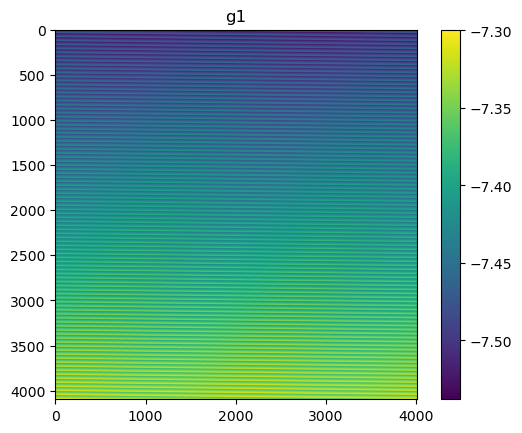

In [12]:
plt.imshow(g1_fd)
plt.colorbar()
plt.title('g1')

f = fits.open('./eimage_00182850-0-i-R22_S11-det000.fits')
w = WCS(f[0].header)

x, y = 0, 0

# 1) subtract off CRPIX
x -= w.wcs.crpix[0]
y -= w.wcs.crpix[1] 

# 2) SIP
w.sip.a[1, 0] += 1
w.sip.b[0, 1] += 1
f = 0
df_dx = 0
for p in range(w.sip.a_order+1):
    for q in range(w.sip.a_order+1):
        f += w.sip.a[p, q] * jnp.power(x, p) * jnp.power(y, q)
        df_dx += p * w.sip.a[p, q] * jnp.power(x, p-1) * jnp.power(y, q)
        
g = 0
dg_dx = 0
for p in range(w.sip.a_order+1):
    for q in range(w.sip.a_order+1):
        g += w.sip.b[p, q] * jnp.power(x, p) * jnp.power(y, q)
        dg_dx += p * w.sip.b[p, q] * jnp.power(x, p-1) * jnp.power(y, q)

x += f
y += g

# 3) Apply CD
u, v = w.wcs.cd @ np.array([x, y])
print(u, v)
factor = 1. * degrees / radians
u *= -factor
v *= factor

# 4) turn u, v into ra, dec
center = galsim.CelestialCoord(w.wcs.crval[0] * degrees, w.wcs.crval[1] * degrees)
ra, dec = center.deproject_rad(u, v, "gnomonic")
ra *= radians / degrees